In [2]:
import numpy as np
import pandas as pd
spotify = pd.read_csv("../data/data_principal.csv")

# testing 
'''
spotify.head()
spotify.info()
'''


'\nspotify.head()\nspotify.info()\n'

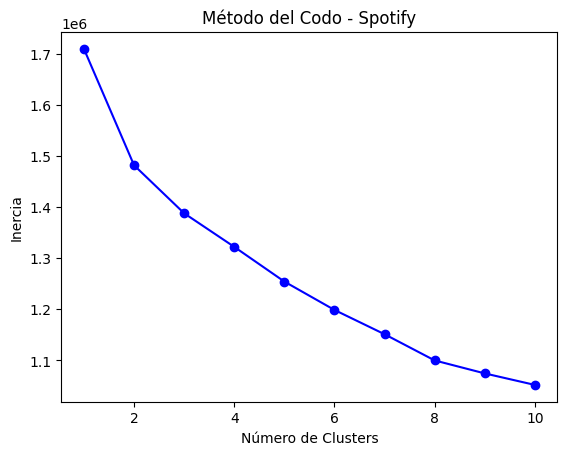

k = 2, Silhouette Score = 0.188
k = 3, Silhouette Score = 0.098
k = 4, Silhouette Score = 0.086
k = 5, Silhouette Score = 0.099
k = 6, Silhouette Score = 0.089
k = 7, Silhouette Score = 0.090
k = 8, Silhouette Score = 0.099
k = 9, Silhouette Score = 0.087
k = 10, Silhouette Score = 0.086


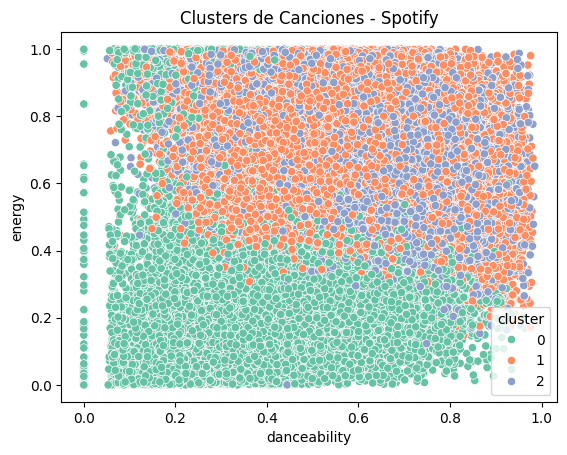

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar solo columnas numéricas
spotify_num = spotify.select_dtypes(include=["float64", "int64"])

# Eliminar filas con valores faltantes (puedes imputar si prefieres)
spotify_num = spotify_num.dropna()

# Guardar las columnas originales por si se necesitan luego
columnas_originales = spotify_num.columns


scaler = StandardScaler()
X_scaled = scaler.fit_transform(spotify_num)


inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bo-')
plt.xlabel("Número de Clusters")
plt.ylabel("Inercia")
plt.title("Método del Codo - Spotify")
plt.show()


for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k = {k}, Silhouette Score = {score:.3f}")


k_optimo = 3
kmeans = KMeans(n_clusters=k_optimo, random_state=0)
clusters = kmeans.fit_predict(X_scaled)

# Guardar los clusters en el DataFrame original
spotify['cluster'] = clusters


sns.scatterplot(data=spotify, x="danceability", y="energy", hue="cluster", palette="Set2")
plt.title("Clusters de Canciones - Spotify")
plt.show()



Silhouette Score: 0.13


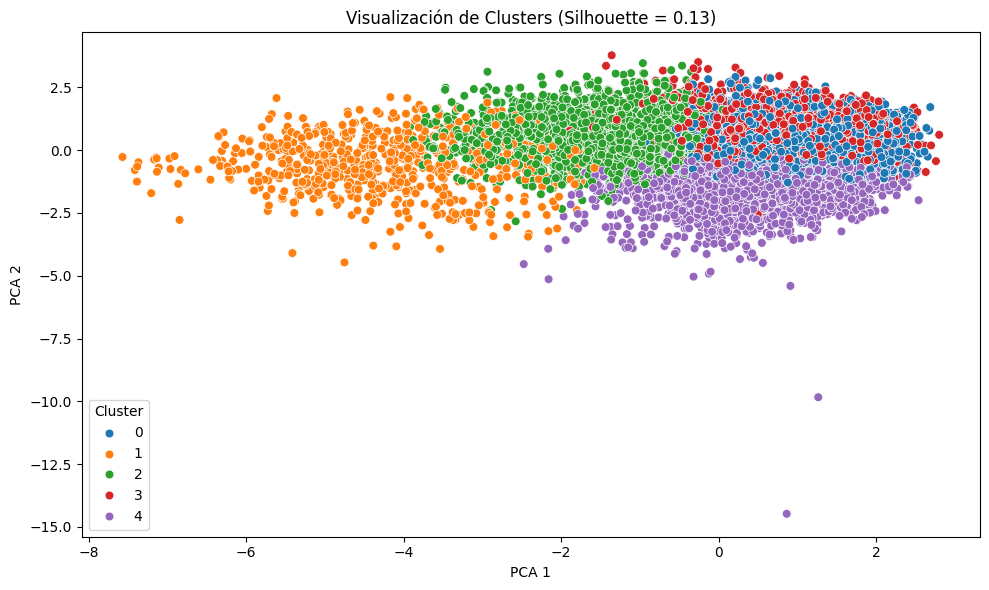

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Columnas numéricas relevantes para clustering
numeric_cols = [
    'popularity', 'duration_ms', 'danceability', 'energy',
    'loudness', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence', 'tempo'
]

# Asegurarse de que los datos son numéricos y eliminar nulos
spotify[numeric_cols] = spotify[numeric_cols].apply(pd.to_numeric, errors='coerce')
df_clean = spotify.dropna(subset=numeric_cols)

# 🔹 Muestreo aleatorio (por ejemplo, 10,000 canciones)
df_sample = df_clean.sample(n=10000, random_state=42)

# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_sample[numeric_cols])

# Clustering con K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
df_sample['cluster'] = kmeans.fit_predict(X_scaled)

# Evaluar calidad del clustering
score = silhouette_score(X_scaled, df_sample['cluster'])
print(f"Silhouette Score: {score:.2f}")

# 🎨 Visualización en 2D con PCA (solo para graficar)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=df_sample['cluster'], palette='tab10', s=40)
plt.title(f'Visualización de Clusters (Silhouette = {score:.2f})')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [5]:
# Agrupar por número de cluster y calcular promedio de cada variable numérica
cluster_summary = df_sample.groupby('cluster')[numeric_cols].mean()

# Redondear los valores para facilitar la lectura
cluster_summary_rounded = cluster_summary.round(2)

# Mostrar resumen
print("Resumen de características promedio por cluster:")
print(cluster_summary_rounded)

Resumen de características promedio por cluster:
         popularity  duration_ms  danceability  energy  loudness  speechiness  \
cluster                                                                         
0             52.40    215308.42          0.62    0.75     -5.97         0.07   
1             27.01    216337.29          0.36    0.21    -20.49         0.05   
2             33.38    215004.63          0.52    0.37    -10.84         0.05   
3             13.12    210218.57          0.70    0.71     -6.80         0.15   
4             27.92    273070.02          0.46    0.83     -6.19         0.09   

         acousticness  instrumentalness  liveness  valence   tempo  
cluster                                                             
0                0.19              0.02      0.25     0.60  124.51  
1                0.84              0.80      0.18     0.20  104.70  
2                0.70              0.06      0.18     0.39  113.84  
3                0.22              0.0

Silhouette Score: 0.07
Clusters encontrados (incluyendo ruido): 7


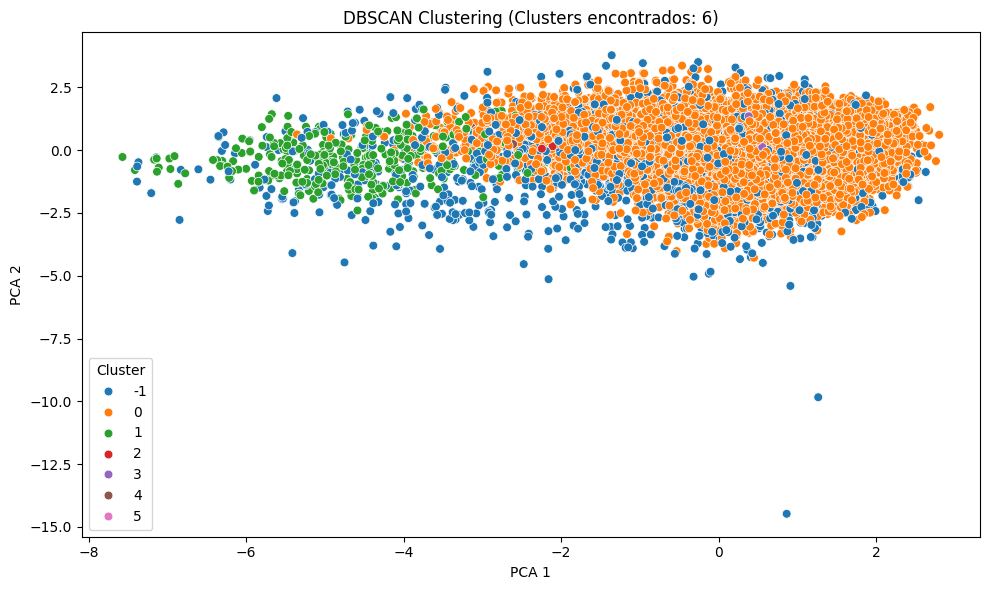

In [7]:
from sklearn.cluster import DBSCAN

# Clustering con DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=10)
df_sample['cluster'] = dbscan.fit_predict(X_scaled)

# Evaluación (solo si hay más de 1 cluster válido)
n_clusters = len(set(df_sample['cluster'])) - (1 if -1 in df_sample['cluster'].unique() else 0)
if n_clusters > 1:
    score = silhouette_score(X_scaled, df_sample['cluster'])
    print(f"Silhouette Score: {score:.2f}")
else:
    print("No se puede calcular Silhouette Score (menos de 2 clusters encontrados)")

print(f"Clusters encontrados (incluyendo ruido): {df_sample['cluster'].nunique()}")

# Visualización con PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=df_sample['cluster'], palette='tab10', s=40)
plt.title(f'DBSCAN Clustering (Clusters encontrados: {n_clusters})')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [8]:
# Resumen por cluster (excluyendo ruido -1 si lo deseas)
cluster_summary = df_sample[df_sample['cluster'] != -1].groupby('cluster')[numeric_cols].mean().round(2)
print("\nResumen de características promedio por cluster:")
print(cluster_summary)


Resumen de características promedio por cluster:
         popularity  duration_ms  danceability  energy  loudness  speechiness  \
cluster                                                                         
0             33.59    223674.88          0.58    0.68     -7.08         0.07   
1             32.12    192888.86          0.38    0.15    -20.68         0.04   
2             19.57    142804.00          0.60    0.36    -12.08         0.06   
3             22.30    185082.00          0.56    0.77     -9.92         0.93   
4             45.40    121376.00          0.65    0.39    -12.24         0.07   
5             18.25    182112.75          0.64    0.52    -10.09         0.06   

         acousticness  instrumentalness  liveness  valence   tempo  
cluster                                                             
0                0.27              0.08      0.20     0.50  123.39  
1                0.92              0.88      0.12     0.18  105.52  
2                0.93    